# Baseline scores

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import xarray as xr
import xskillscore as xs
import skimage
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/utils"
os.chdir(path)
import dataset
import rescaling
import metrics

Let's get the files

In [2]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/HadGEM_driven_COSMO/Present/2003"
os.chdir(path)
filenames = dataset.getfiles()
print(filenames[0:24])

['lffd20030101000000.nc', 'lffd20030101010000.nc', 'lffd20030101020000.nc', 'lffd20030101030000.nc', 'lffd20030101040000.nc', 'lffd20030101050000.nc', 'lffd20030101060000.nc', 'lffd20030101070000.nc', 'lffd20030101080000.nc', 'lffd20030101090000.nc', 'lffd20030101100000.nc', 'lffd20030101110000.nc', 'lffd20030101120000.nc', 'lffd20030101130000.nc', 'lffd20030101140000.nc', 'lffd20030101150000.nc', 'lffd20030101160000.nc', 'lffd20030101170000.nc', 'lffd20030101180000.nc', 'lffd20030101190000.nc', 'lffd20030101200000.nc', 'lffd20030101210000.nc', 'lffd20030101220000.nc', 'lffd20030101230000.nc']


Let's now work with the values for an entire day

In [3]:
day_2km = dataset.new_dataset(filenames, 172, 173)
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/data"
day_2km = day_2km.drop('lon')
day_2km = day_2km.drop('lat')
os.chdir(path)
day_2km

<xarray.Dataset>
Dimensions:     (time: 24, rlon: 1542, rlat: 1542)
Coordinates:
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
    height_2m   float32 2.0
    height_10m  float32 10.0
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.5 283.5
    RELHUM_2M   (time, rlat, rlon) float32 79.83 79.32 79.08 ... 79.15 79.35
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

In [4]:
lat_bnd = [-4, 2]
lon_bnd = [-4, 5]
dataset.save_dataset(day_2km, 'day_2km')

saving to  ./day_2km.nc
finished saving


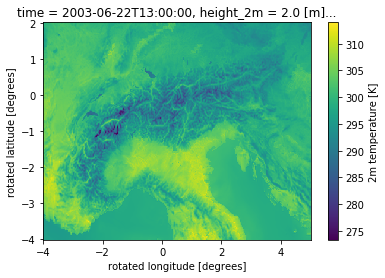

In [5]:
day_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 13).plot()

In this notebook, it will be interesting to look at the different metrics that can be used, to see how the baselines are performing

6 metrics will be used to compare the downscalings : RMSE, MAE, SSIM, spatial autocorrelation, Hellinger distance and Perkins score. We will compare the downscaled images with the original image

## Data preparation

### Upscaling

In [ ]:
ingrid = rescaling.create_grid(-18.86, 11.98, 0.02, -14.86, 15.98, 0.02)
outgrid = rescaling.create_grid(-18.86, 11.9, 0.12, -14.86, 15.9, 0.12)

In [ ]:
ups_ds = rescaling.upscale(day_2km, ingrid, outgrid)

Overwrite existing file: conservative_1542x1542_257x257.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('rlat', 'rlon') from data variable T_2M as the horizontal dimensions for this dataset.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/env/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


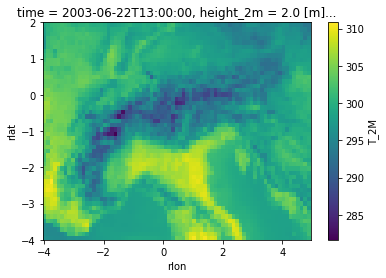

In [ ]:
ups_ds.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 13).plot()

### Downscaling

Let's do bilinear remapping, bicubic and quintic

In [ ]:
bilin_2km = xr.full_like(day_2km, 0)
rescaling.downscale(ups_ds, bilin_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'linear')

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.8 283.8
    RELHUM_2M   (time, rlat, rlon) float32 79.63 79.99 80.35 ... 78.44 78.44
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

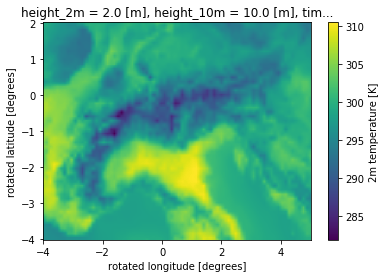

In [ ]:
bilin_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

In [11]:
bicubic_2km = xr.full_like(day_2km, 0)
rescaling.downscale(ups_ds, bicubic_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'cubic')

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.8 293.8 ... 283.8 283.8
    RELHUM_2M   (time, rlat, rlon) float32 79.63 80.1 80.52 ... 78.44 78.44
    TOT_PR      (time, rlat, rlon) float32 -2.997e-36 5.443e-34 ... 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

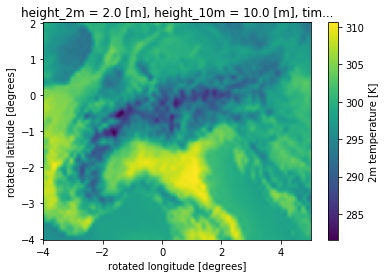

In [12]:
bicubic_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

In [13]:
quintic_2km = xr.full_like(day_2km, 0)
rescaling.downscale(ups_ds, quintic_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'quintic')

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.8 283.8
    RELHUM_2M   (time, rlat, rlon) float32 79.63 80.21 80.66 ... 78.44 78.44
    TOT_PR      (time, rlat, rlon) float32 -9.898e-33 1.326e-29 ... 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

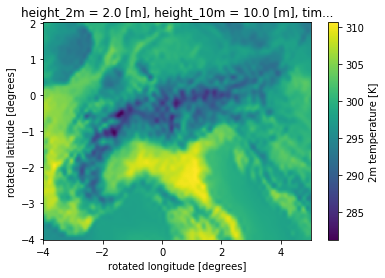

In [14]:
quintic_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

# RMSE 

It is one of the easiest metrics

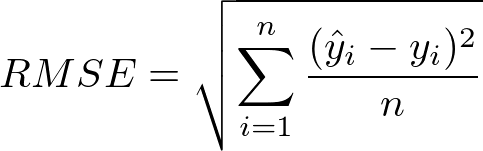

In [15]:
bil_RMSE = xs.rmse(day_2km, bilin_2km, dim = ['rlon','rlat'])
bic_RMSE = xs.rmse(day_2km, bicubic_2km, dim = ['rlon','rlat'])
quintic_RMSE = xs.rmse(day_2km, quintic_2km, dim = ['rlon','rlat'])

RMSE = [bil_RMSE, bic_RMSE, quintic_RMSE]

# MAE

Easy to understand too 

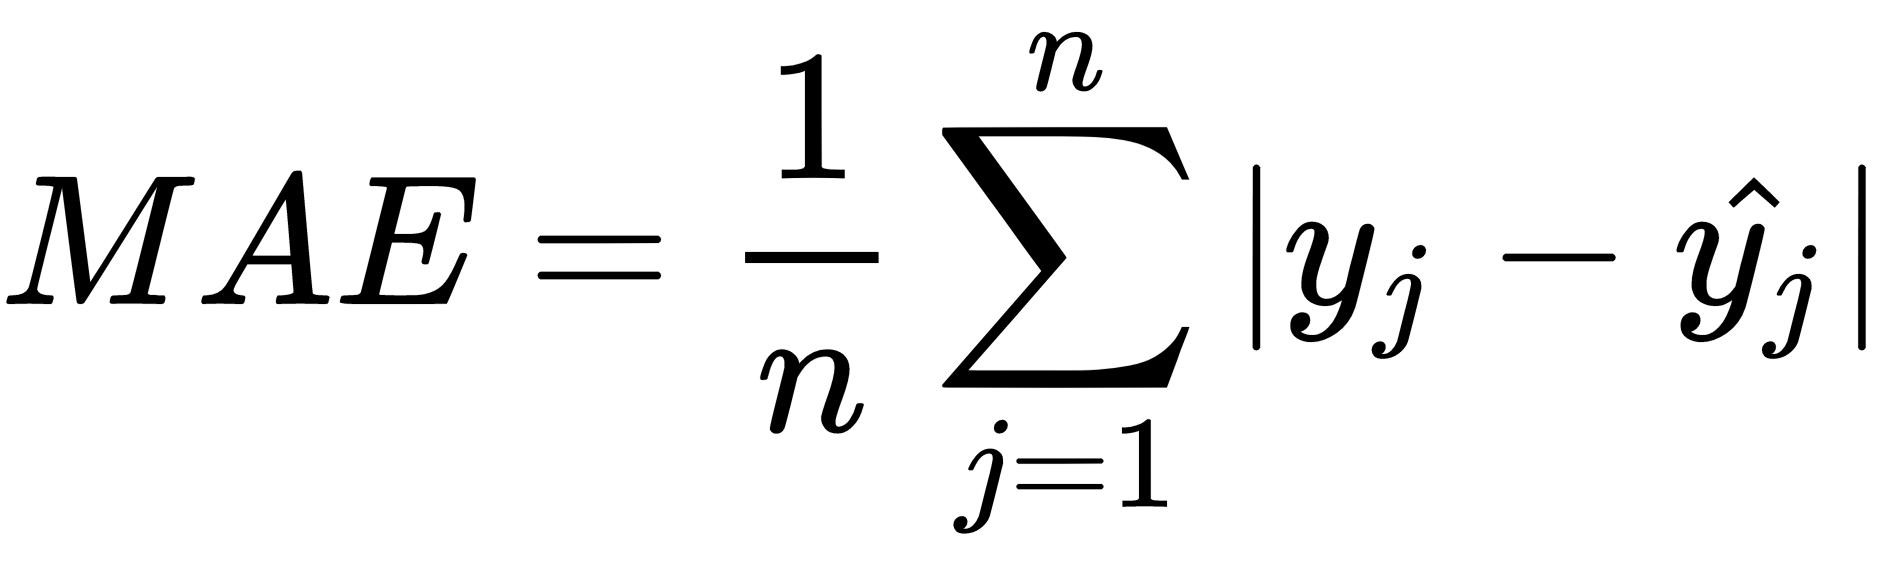

In [16]:
bil_MAE = xs.mae(day_2km, bilin_2km, dim = ['rlon','rlat'])
bic_MAE = xs.mae(day_2km, bicubic_2km, dim = ['rlon','rlat'])
quintic_MAE = xs.mae(day_2km, quintic_2km, dim = ['rlon','rlat'])

MAE = [bil_MAE, bic_MAE,quintic_MAE]

# SSIM

This website is quite clear on how it works (plus code) : https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e

In [17]:
bil_SSIM = metrics.SSIM(day_2km, bilin_2km)
bic_SSIM = metrics.SSIM(day_2km, bicubic_2km)
quintic_SSIM = metrics.SSIM(day_2km, quintic_2km)

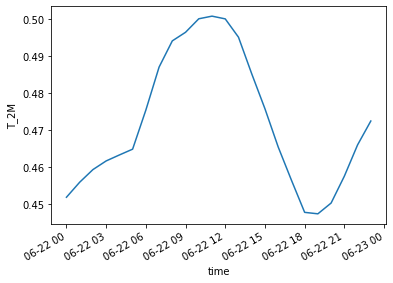

In [18]:
(1-bil_SSIM.T_2M).plot()

# Spatial autocorelation

# Hellinger distance

I didn't found a function for the Helllinger distance, so I tried to do one following wikipedia's discrete distribution :
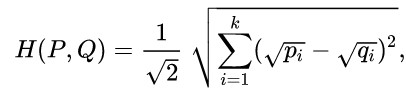

In [ ]:
bil_H = metrics.Hellinger(day_2km, bilin_2km)

In [ ]:
bil_H

In [21]:
bilin_2km.T_2M.isel(time = 0).values[2][3]

293.8742

# Perkins score